<a href="https://colab.research.google.com/github/said-mk/ML-Projects/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Handwritten Digit Recognition in PyTorch

### Modules used


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader

### Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

### Dataset and Dataloader

used MNIST Handwritten Digit from

```
torchvision.datasets
```
and used Dataloder to load it in batches of 64



In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    transform=transforms.ToTensor(),
    download=True,
    train=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]


In [3]:
train_loader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=64,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    dataset= test_data,
    pin_memory=True,
    num_workers=4,
    batch_size=64,
    shuffle=False
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Model Architecture

In [4]:
class MNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.conv3 = nn.Conv2d(64,128,3,1)
    self.flatten = nn.Flatten()
    self.dropout1= nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(1152,128)
    self.fc2 = nn.Linear(128,10)

  def forward(self,x):
    # First Conv layer
    x  = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2)
    x = self.dropout1(x)

    # Second Conv Layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,2)
    x = self.dropout1(x)

    # Third Conv Layer
    x = self.conv3(x)
    x = F.relu(x)
    x = self.dropout1(x)

    # Dense Layer
    x = self.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)

    # classifaction logits
    logits = self.fc2(x)

    return logits

model = MNISTNet().to(device)

### Training Loop

will be used to train the model

In [5]:
def train_loop(model,loader,device,criterion,optimizer):
  model.train()
  size = len(loader.dataset)

  for batch_idx, (data,target) in enumerate(loader):
    data = data.to(device)
    target = target.to(device)

    # prediction and loss
    predictions = model(data)
    loss = criterion(predictions, target)

    # Backpropaagtion
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_idx % 100 == 0:
      loss = loss.item()
      current = batch_idx * batch_size + len(data)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Testing Loop

will be use to evaluate the model (accurracy on unseen sample)

In [6]:
def test_loop(model,loader,criterion,device):
  model.eval()
  total_sample = len(loader.dataset)
  num_batches = len(loader)
  test_loss = 0
  correct_pred = 0



  with torch.no_grad():
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      predictions = model(data)
      loss = criterion(predictions,target)

      test_loss += loss.item()
      # Accumulate loss (weighted by batch size for accurate average)
      # test_loss += loss.item() * data.size(0)
      correct_pred += (predictions.argmax(1) == target).type(torch.float).sum().item()

    test_loss = test_loss/num_batches
    correct_pred = correct_pred/total_sample

    print(f"Test Error: \n Accuracy: {(100*correct_pred):>0.1f}%, Avg loss: {test_loss:>8f} \n")



### Hyperparameters

adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates

In [7]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training and evaluating model

In [8]:
for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_loop(model,train_loader,device,loss_fn,optimizer)
  test_loop(model,test_loader,loss_fn,device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.315014  [   64/60000]
loss: 2.285228  [ 6464/60000]
loss: 2.315535  [12864/60000]
loss: 2.311386  [19264/60000]
loss: 2.300491  [25664/60000]
loss: 2.292942  [32064/60000]
loss: 2.292917  [38464/60000]
loss: 2.303175  [44864/60000]
loss: 2.303821  [51264/60000]
loss: 2.310831  [57664/60000]
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.298594 

Epoch 2
-------------------------------
loss: 2.297364  [   64/60000]
loss: 2.292327  [ 6464/60000]
loss: 2.298768  [12864/60000]
loss: 2.291347  [19264/60000]
loss: 2.287547  [25664/60000]
loss: 2.308015  [32064/60000]
loss: 2.291116  [38464/60000]
loss: 2.311653  [44864/60000]
loss: 2.301008  [51264/60000]
loss: 2.293400  [57664/60000]
Test Error: 
 Accuracy: 24.3%, Avg loss: 2.292574 

Epoch 3
-------------------------------
loss: 2.289963  [   64/60000]
loss: 2.306777  [ 6464/60000]
loss: 2.280674  [12864/60000]
loss: 2.292750  [19264/60000]
loss: 2.295671  [25664/60000]
loss: 2.297112  [32064/600

### Saving the Model
save the trained model. saving model saves re-**training** it every time you want to use it for predictions.

In [9]:
torch.save(model.state_dict(), "mnist_cnn.pth")


### Testing the model and visualizaing test sample

In [41]:
def visualize_test_samples(model, loader, device, num_images=5):
    model.eval()

    try:
        data_iter = iter(loader)
        images, targets = next(data_iter)
    except StopIteration:
        print("Error: DataLoader is empty or finished.")
        return

    if num_images > 12:
      print("Max number of image = 12")
      print("Maximun number images exceed!")
      print("Images reduced to 12.")
      num_images = 12

    images = images.to(device)

    # Predictions
    with torch.no_grad():
        logits = model(images)
        # Get the predicted class index
        predictions = logits.argmax(1).cpu().numpy()

    # Move original data to CPU for plotting
    images_cpu = images.cpu().numpy()
    targets_cpu = targets.cpu().numpy()


    plot_count = num_images
    fig, axes = plt.subplots(1, plot_count, figsize=(15, 3.5))

    print(f"\nDisplaying {plot_count} predictions:")

    if num_images == 1: # Error Handling:
      axes = [axes]     # TypeError: 'Axes' object is not subscriptable
    for i in range(plot_count):
        image = images_cpu[i].squeeze()

        true_label = targets_cpu[i]
        predicted_label = predictions[i]

        # Set color and text for visualization
        color = 'green' if true_label == predicted_label else 'red'

        # Plot the image
        axes[i].imshow(image, cmap='gray')

        # Predicted Label
        axes[i].set_title(f"Predicted: {predicted_label}", color=color, fontsize=10)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


Displaying 3 predictions:


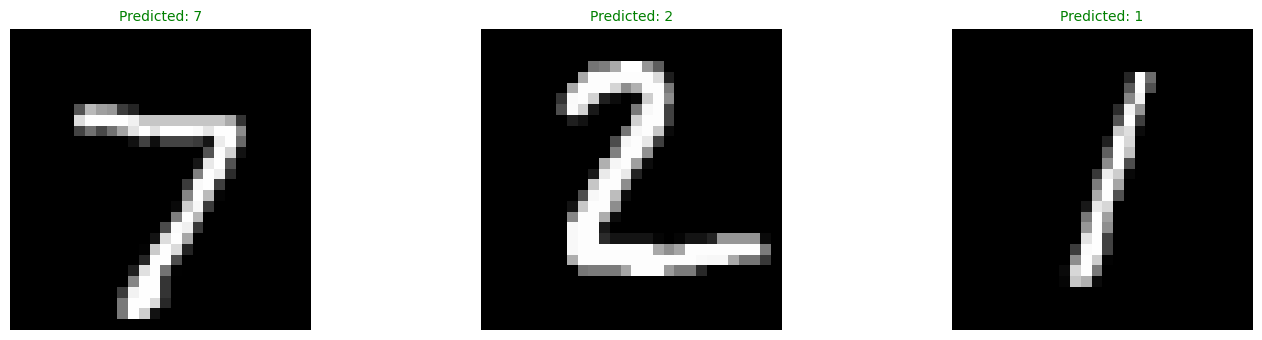

In [47]:
num_images = torch.randint(1,10,[1]).item()

visualize_test_samples(model, test_loader, device, num_images=num_images)